# A Julia Implementation of Self-driven particles model
## Author: Matias Pomata

## Implementation of Vicsek $et$ $al.$ model for self-driven particles using Julia programming language. The implementation uses the cell-linked algorithm for optimization of particle-particle interaction calculations.

## The model:

### initial conditions:
- at $t=0$, $N$ particles are distibuted on a square of lenght $L$
- all particles have the same speed (absolute value of the velocity)
- the velocity directions are chosen ramdomly forming an angle $\theta$ with the $x$ axis
- on each time step the velocity of every particle is calculated taking the average from velocities of   the surrounding particles within a circle of radius $r_{c}$ , we denote this average by $< >_{r_{c}}$

### Velocities and positions updates:

### so, at each time step we make the following updates:
- $\theta(t+1)$ = $<\theta(t)>_{r_{c}}$ + $\eta$, where $\eta$ is a random *noise* number
- $\mathbf{x}_{i}(t+1)$ = $\mathbf{x}_{i}(t)$+ $\mathbf{v}_{i}$.$\Delta t$

In [1]:
using Plots; gr()

Plots.GRBackend()

In [2]:
function mapas(m)
"""
    This function is a 2D variation of Allen and Tildesley subroutine the generates the cell-linked 
    mapping from the simulation cells.
    
"""
    ncell = m*m
    mapsize = 4*ncell
    maps = zeros(Int64,mapsize,1);
#half of cells
    for iy=1:m
        for ix=1:m
            imap = (icell(ix,iy,m)-1)*4
            maps[imap+1]=icell(ix+1,iy  ,m)
            maps[imap+2]=icell(ix+1,iy+1,m)
            maps[imap+3]=icell(ix  ,iy+1,m)
            maps[imap+4]=icell(ix-1,iy+1,m)
        end
    end
    return maps
end
#***********************************************************************
function icell(ix,iy,m)
  1+rem(ix-1+m,m)+rem(iy-1+m,m)*m
end
#***********************************************************************

function linkos(ncell,m,rc,Nparts,L,rx,ry)
"""
    SUBROUTINE TO SET UP LINKED LIST AND THE HEAD OF CHAIN ARRAYS
"""
   head = zeros(ncell,1)
   list = zeros(Nparts,1)
   celli = m
   cell = 1/m
   if cell < rc/celli
      println("cell dimension is smaller than rc")
   end
   head = zeros(Int64,ncell,1)
   list = zeros(Int64,Nparts,1)
   celli = m
   cell = 1/m
   if cell < rc/celli
      println("cell dimension is smaller than rc")
   end
#sort all particles
   for i = 1:Nparts
      iicell = 1+floor((rx[i]+0.5)*celli)+floor((ry[i]+0.5)*celli)*m
      icell = Int64(iicell)
      #scatter!(rx[i],ry[i])
      list[i] = head[icell]
      head[icell] = i
   end
   return head, list
end
#************************************************************************


linkos (generic function with 1 method)

In [3]:
function spp2(Maxsteps,rc,NParts,v0,density,etha,dt)
    
    L = sqrt(NParts/density) #box lenght
    Lhalf = L*0.5
    m = Int(ceil(L/(1.1*rc)))
    dtick = trunc(L/m,digits=0)
    ϵ = 0.1
    rcsqr = rc^2
    #initial positions on a square of side L
    xini = rand(-Lhalf+ϵ:0.01:Lhalf-ϵ,NParts,1)
    yini = rand(-Lhalf+ϵ:0.01:Lhalf-ϵ,NParts,1)
    LhalfTrunc = trunc(Lhalf,digits=0)
    Ticks = collect(-LhalfTrunc:dtick:LhalfTrunc)
    #initial velocities directions
    thetaini = rand(-pi:0.01:pi,NParts,1)
    vxini = v0*cos.(thetaini)
    vyini = v0*sin.(thetaini)
    p1 = quiver(xini[:],yini[:],quiver=(vxini[:],vyini[:]),
                lims = (-Lhalf,Lhalf),ticks = Ticks,
                title="Self-driven particles simulation")
    # p1=scatter(xini,yini, series_annotations = text.(1:NParts,:bottom),
    #         lims = (-L*0.5,L*0.5),
    #         ticks = Ticks)
    display(p1)
    #vector initialization
    vx = zeros(NParts,1)
    vy = zeros(NParts,1)
    x = zeros(NParts,1)
    y = zeros(NParts,1)
    ncell = m*m
    map = mapas(m)
    #set up animation if needed
    for n =1:Maxsteps
       vxtot=0.0;vytot=0.0
    #loop over all cells
       head,list = linkos(ncell,m,rc,NParts,L,xini/L,yini/L)
       for icell = 1:ncell
           vxavg=0.0;vyavg=0.0;
           i = head[icell]
           #loop over particles in the cell
           while i>0
               rx = xini[i]
               ry = yini[i]
               #loop over all particles below i in the current cell
               j = list[i]
               while j>0;
                   dx = rx-xini[j]
                   dy = ry-yini[j]
                   #minimum image convention
                   dx = dx-round(dx)
                   dy = dy-round(dy)
                   drsqr = dx^2+dy^2
                   if drsqr<rcsqr
                       vxavg +=vxini[j]
                       vyavg +=vyini[j]
                   end
                   j = list[j]
               end
               #loop over neighboring cells
               jcell0 = 4*(icell-1)
               for nabor = 1:4
                   jcell = map[jcell0+nabor]
                   if jcell > 0
                   #loop over all particles in neighboring cells
                       j = head[jcell]
                       while j != 0
                           dx = rx - xini[j]
                           dy = ry - yini[j]
                           #minimum image convention
                           dx = dx-round(dx)
                           dy = dy-round(dy)
                           drsqr = dx^2+dy^2
                           if drsqr < rcsqr
                               vxavg += vxini[j]
                               vyavg += vyini[j]
                           end
                           j = list[j]
                       end
                   end
               end
               #Avergae velocities calc
               vavgmod = sqrt(vxavg^2+vyavg^2);
               if vavgmod!=0.0;vxavg = vxavg/vavgmod;vyavg = vyavg/vavgmod end
               #noise introduction
               noise = rand(-pi:0.01:pi)*etha
               theta = thetaini[i]
               if vxavg!=0.0;theta = atan(vyavg/vxavg)+noise end
               #new velocities
               vx[i]=v0*cos(theta);
               vy[i]=v0*sin(theta);
               #new positions
               x[i] = xini[i]+dt*vx[i]
               y[i] = yini[i]+dt*vy[i]
               #periodic boundary conditions
               if x[i] <  Lhalf; x[i] += L end
               if x[i] >= Lhalf; x[i] -= L end
               if y[i] <  Lhalf; y[i] += L end
               if y[i] >= Lhalf; y[i] -= L end
               #Overall average velocity parameter
               vxtot += vx[i]
               vytot += vy[i]
               i = list[i]
           end
       end
#       psi[n] = sqrt(vxtot^2+vytot^2)/v0/NParts;

       #velocity vector field graph for animation
       quiver(x[:],y[:],quiver=(vx[:],vy[:]),
              lims = (-Lhalf,Lhalf), ticks = Ticks,
              title="Self-driven particles simulation")
        
       #positions and velocities update
       xini = x;
       yini = y;
       vxini = vx;
       vyini = vy;
    end
end


spp2 (generic function with 1 method)

In [4]:
#Parameters:

Maxsteps = 10  # number of simulations steps
rc = 1.0        # radius of particle search for average velocity calc. 
NParts = 300    # number of particles
v0 = 0.3        # particles constants absolute velocity 
density = 0.5   # particles density  
etha = 0.1      # stocastic noise max. value
dt = 1.0        # time step

1.0

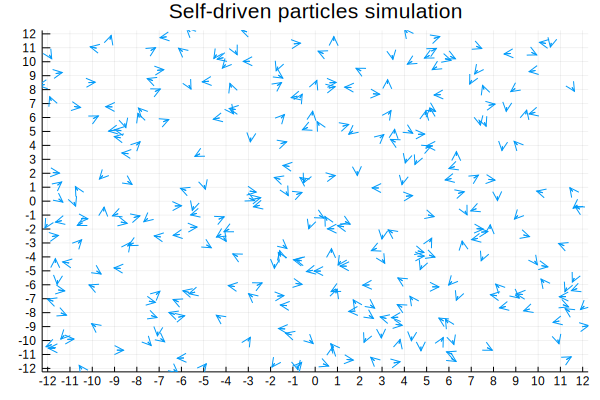

In [5]:
spp2(Maxsteps,rc,NParts,v0,density,etha,dt)